In [36]:
# -*- coding: utf-8 -*-

import numpy as np
import math
import time

import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [37]:
def sample_noise(Sigma, T=10.0, dt=0.5, num_trajs=500, n=2) :
    if len(Sigma) != n :
        n = len(Sigma)
    time_steps = math.floor(T/dt)
    noise_samples = np.random.multivariate_normal(np.zeros(n), Sigma , [num_trajs,time_steps])
    return noise_samples

def stage_cost(dist2, dist_weight = 10) :
    return dist_weight*dist2

def term_cost(dist2, goal_reached) :
    return (1 - float(goal_reached)) * dist2

def compute_lambda_theta(theta) :
    return 1/(1 - theta)

def rollout(x0, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost = 10, num_trajs=500, goal_tolerance=0.1) :
    costs = np.zeros(num_trajs)
    # time_steps = len(u_curr) # Haven't defined u_curr yet
    time_steps = int(T//dt)
    goal_reached = False
    goal_tolerance_sq = goal_tolerance ** 2
    dist_to_goal2 = 1e9
    
    x_vis = np.zeros( (20, time_steps, 2) )*np.nan
    n = len(x0)
    
    for k in range(num_trajs) :
        x_curr = np.zeros(n)
        for i in range(n) :
            x_curr[i] = x0[i]
        if k < 20 :
            x_vis[k, 0, :] = x_curr[:2]    
        for t in range(time_steps) :
            # x_curr +=np.array([[0, 0, dt, 0],[0, 0, 0, dt],[0, 0, 0, 0],[0, 0, 0, 0]]) @ x_curr + np.array([[(dt**2)/2, 0],[0, (dt**2)/2],[dt, 0],[0, dt]]) @ (noise_samples[k,t,:])    
            x_curr[0] += dt * ( noise_samples[k,t,0] ) * np.cos(x_curr[2])
            x_curr[1] += dt * ( noise_samples[k,t,0] ) * np.sin(x_curr[2])
            x_curr[2] += dt * ( noise_samples[k,t,1] )
            
                            
            if k < 20 :
                x_vis[k, t, :] = x_curr[:2]    
                
            dist_to_goal2 = (x_goal[0]-x_curr[0])**2 + (x_goal[1]-x_curr[1])**2
            if dist_to_goal2 < 0.01 :
                costs[k] += stage_cost(dist_to_goal2, dist_weight)
                break
            else :
                costs[k] += stage_cost(dist_to_goal2, dist_weight)
                num_obs = len(obs_pos)
                for obs_i in range(num_obs) :
                    op = obs_pos[obs_i]
                    costs[k] += float(x_curr[0] > op[0] and x_curr[0] < op[0] + obs_r[obs_i] and 
                                      x_curr[1] > op[1] and x_curr[1] < op[1] + obs_r[obs_i]) * obs_cost 
                
                # Boundary panalty
                costs[k] += float(x_curr[0] < -4 or x_curr[0] > 1  or
                                  x_curr[1] < -1 or x_curr[1] > 4 )  * obs_cost 
                
                
            if dist_to_goal2 <= goal_tolerance_sq :
                goal_reached = True
                break
            
            # Terminal cost
            costs[k] += term_cost(dist_to_goal2, goal_reached) 
            
            # for t in range(time_steps) :
            #     costs[k] += u_curr[t,:] @ Sigma @ u_curr[t,:]
    return costs, x_vis

In [38]:
def update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2) :
    costs = np.exp( - (costs) / lambda_neut ) 
    sum_costs = np.sum(costs)    
    
 
    time_steps = math.floor(T/dt)
    u_curr = np.zeros((time_steps,n))
    for t in range(time_steps) :
        for k in range(len(costs)) :
            u_curr[t,:] += (costs[k] / sum_costs ) * noise_samples[k,t,:] 

    return u_curr


def update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :    
    num_trajs = len(noise_samples)
    for gamma in gammas :
        lambda_l = 1e-3; lambda_r = 1e3
        # theta_l = -1e10; theta_r = 1e10 
        k = 0
        K = 300        
        while k < K :
            lambda_1 = lambda_l + (lambda_r - lambda_l) / 3
            lambda_2 = lambda_l + 2 * (lambda_r - lambda_l) / 3
            
            opt_cost_1 = gamma / lambda_1 - lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) )
            opt_cost_2 = gamma / lambda_2 - lambda_2 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_2 )  ) )
            # print(- lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) ))
            
            if opt_cost_1 > opt_cost_2:
                lambda_l = lambda_1
            elif opt_cost_1 < opt_cost_2 :
                lambda_r = lambda_2
            
            if lambda_r - lambda_l <= 1e-3:
                break
            
            optimal_cost = min(opt_cost_1, opt_cost_2)
            k += 1

    # if init_report == 0 :
        
    # if init_report % 10 == 0 :
    #     print(lambda_r)
    
    # min_cost = np.min(costs)
    # costs = np.exp( - (costs - min_cost) / lambda_r ) 
    costs = np.exp( - (costs ) / lambda_r ) 
    sum_costs = np.sum(costs)
    
    time_steps = math.floor(T/dt)
    u_curr = np.zeros((time_steps,n))    
    for k in range(len(costs)) :
        u_curr[0,:] += (costs[k] / sum_costs ) * noise_samples[k,0,:] 
    
    return u_curr
 

def update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :
    num_trajs = len(noise_samples)
    lambda_grid = np.linspace(1e-3, 1e3, num_trajs)  # grid of lambda values
    for gamma in gammas :
        opt_costs = []
        for lambda_ in lambda_grid:
            opt_cost = gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))
            opt_costs.append(opt_cost)
        lambda_r = lambda_grid[np.argmin(opt_costs)]  # Select the lambda that gives the minimum cost

        costs = np.exp(-costs / lambda_r) 
        sum_costs = np.sum(costs)

        time_steps = math.floor(T/dt)
        u_curr = np.zeros((time_steps,n))    
        for k in range(len(costs)) :
            u_curr[0,:] += (costs[k] / sum_costs ) * noise_samples[k,0,:] 

    return u_curr



def update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :
    num_trajs = len(noise_samples)

    # Define the cost function wrapper
    def opt_cost_func(lambda_, gamma, costs, num_trajs):
        return gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))

    for gamma in gammas:
        # Alternatively, use the Nelder-Mead method.  'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov'
        result = minimize(opt_cost_func, x0=1.0, args=(gamma, costs, num_trajs), method='Powell', options={'maxiter': 10000})

        if result.success:
            lambda_r = result.x[0]
        else:
            print("Optimization failed for gamma =", gamma)
            continue  # Move on to the next gamma if optimization failed

        costs = np.exp(-costs / lambda_r)
        sum_costs = np.sum(costs)

        time_steps = math.floor(T/dt)
        u_curr = np.zeros((time_steps, n))
        for k in range(len(costs)) :
            u_curr[0,:] += (costs[k] / sum_costs) * noise_samples[k, 0, :]

    return u_curr



In [39]:
def path_integral(Sigma, x0, x_goal, u_curr, dist_weight, obs_cost, obs_pos, obs_r, T, dt, theta, num_trajs, init_report, gammas):
    
    noise_samples = sample_noise(Sigma, T, dt, num_trajs, n=2)
    costs, x_vis = rollout(x0, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost, num_trajs, goal_tolerance=0.1)   
    # u_curr = update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2)
    # u_curr = update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    # u_curr = update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    u_curr = update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    
    return u_curr, x_vis

/var/folders/lf/cvhsltm529q5zyt6s5vt08l00000gn/T/ipykernel_19163/1585582771.py:86: RuntimeWarning: divide by zero encountered in log
  return gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))
/var/folders/lf/cvhsltm529q5zyt6s5vt08l00000gn/T/ipykernel_19163/1585582771.py:86: RuntimeWarning: overflow encountered in exp
  return gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))


Hit obstacle


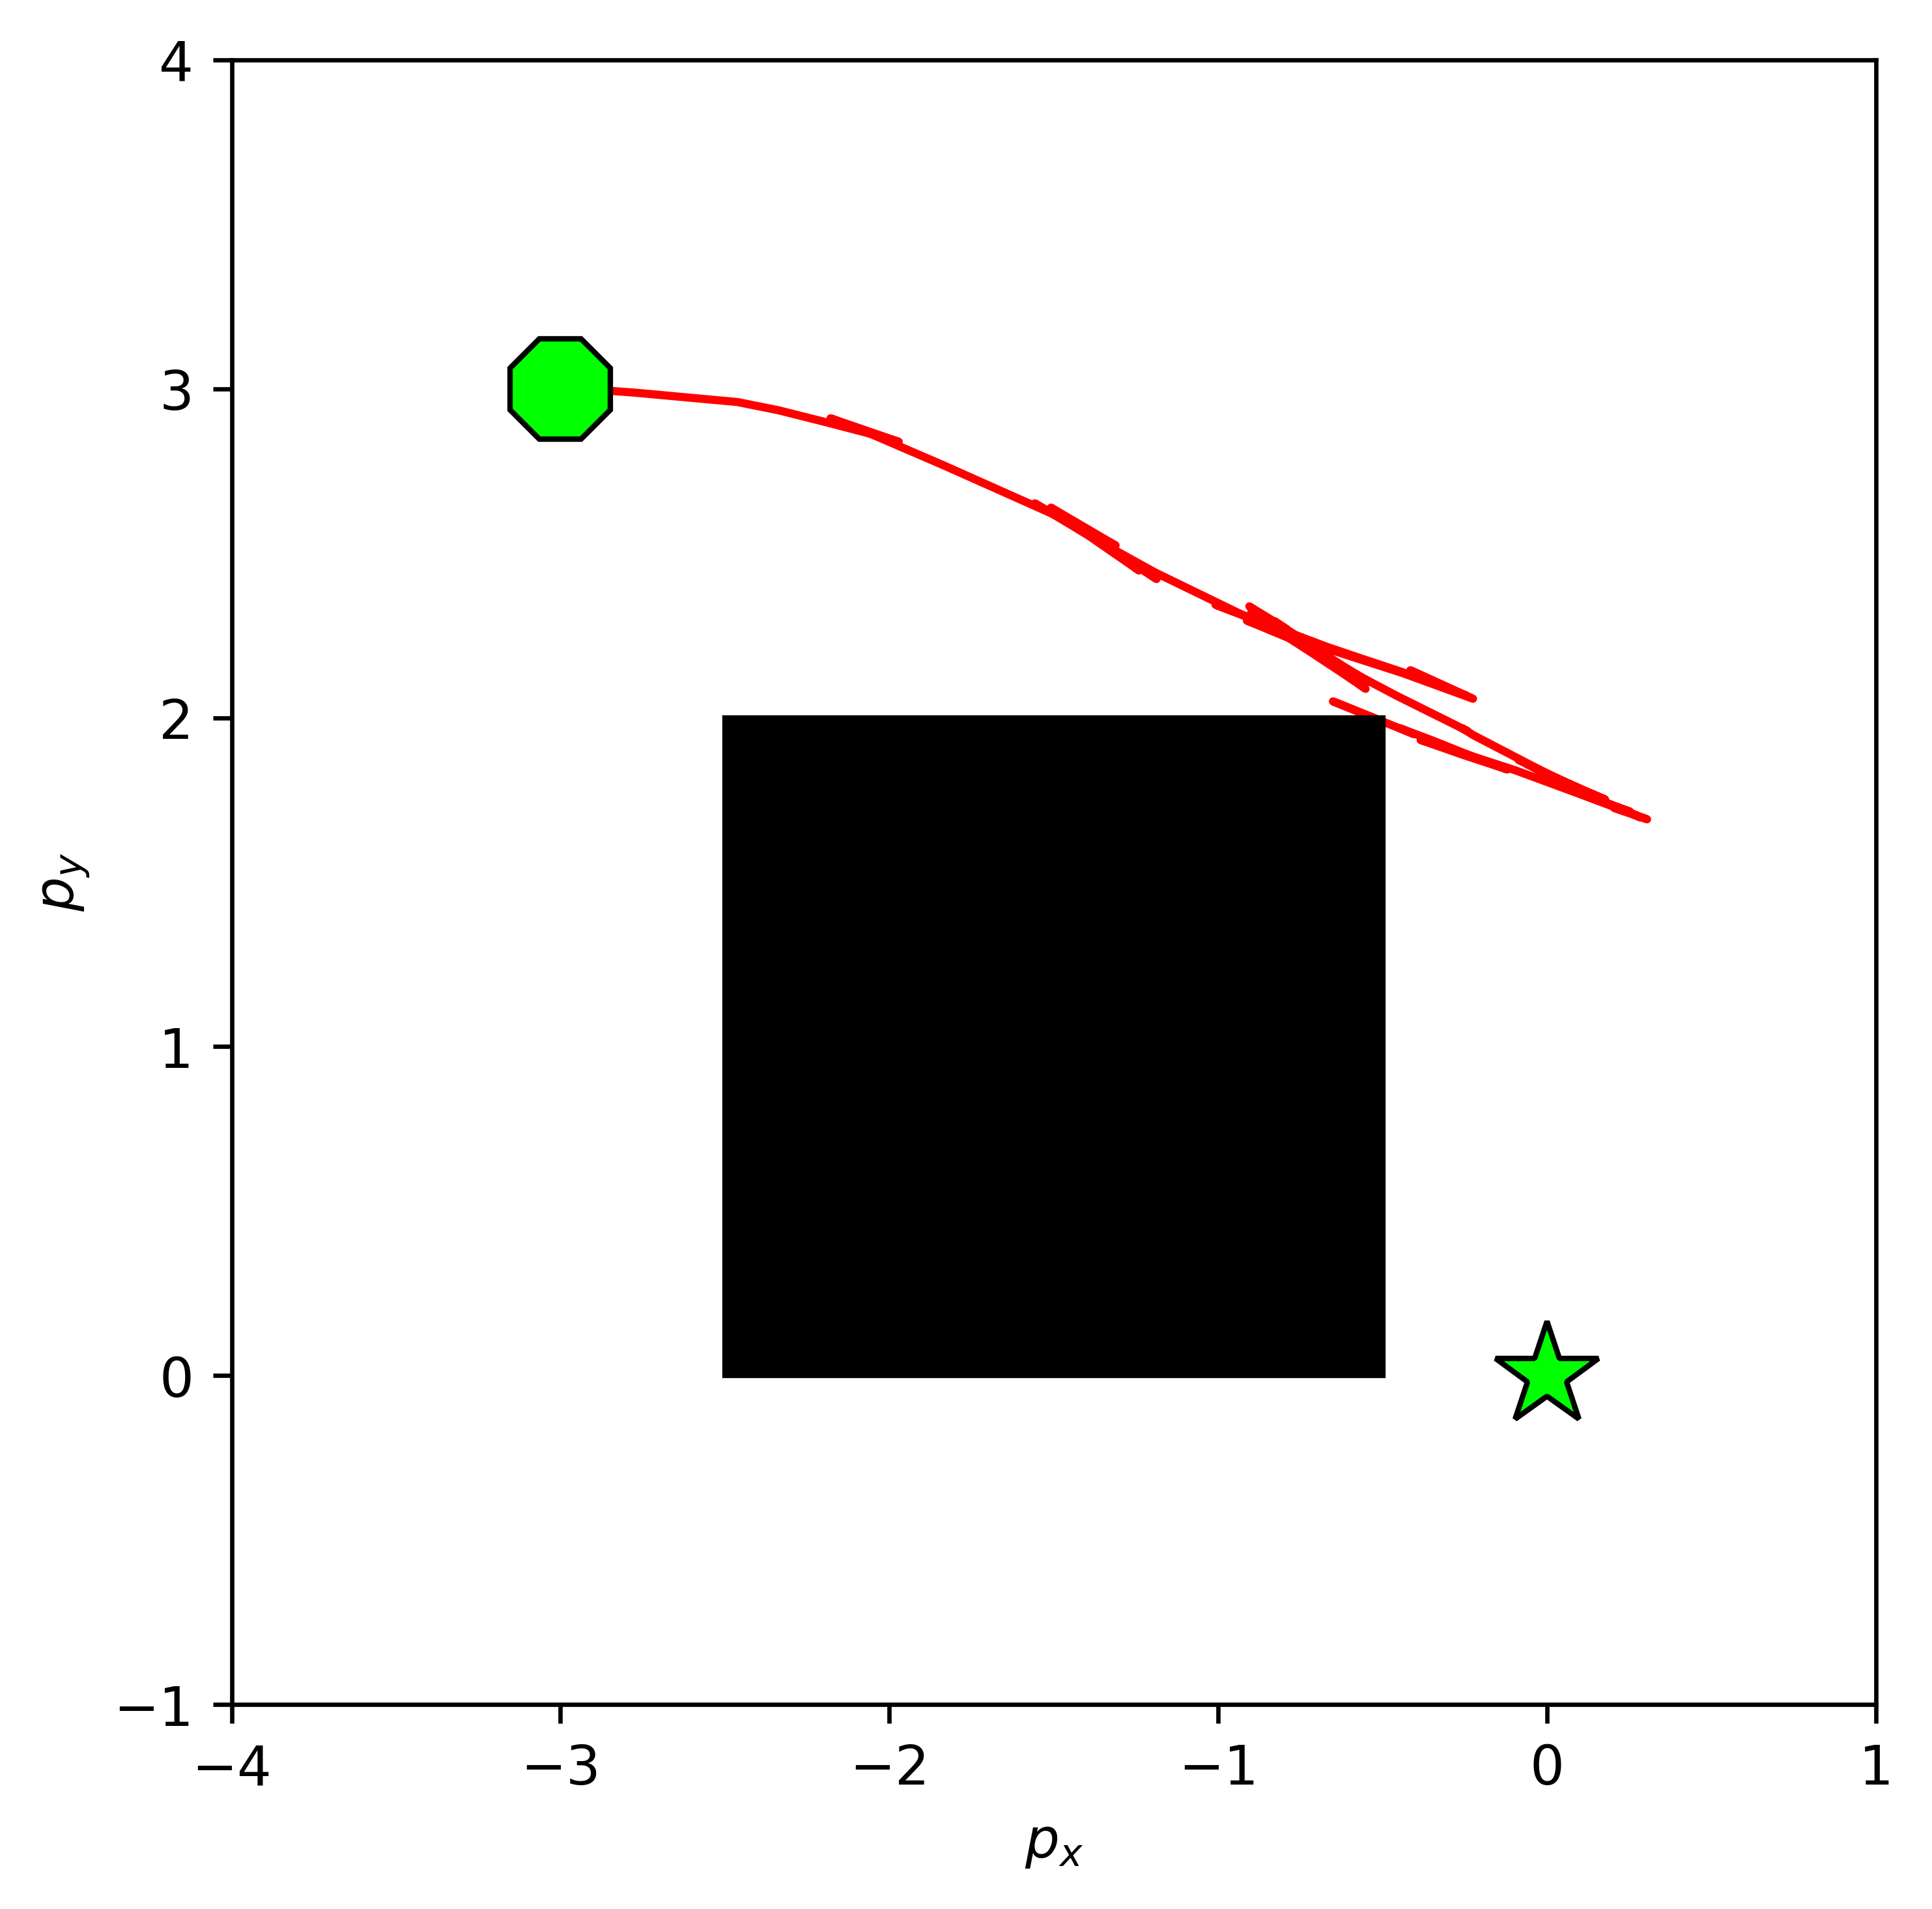

Hit obstacle


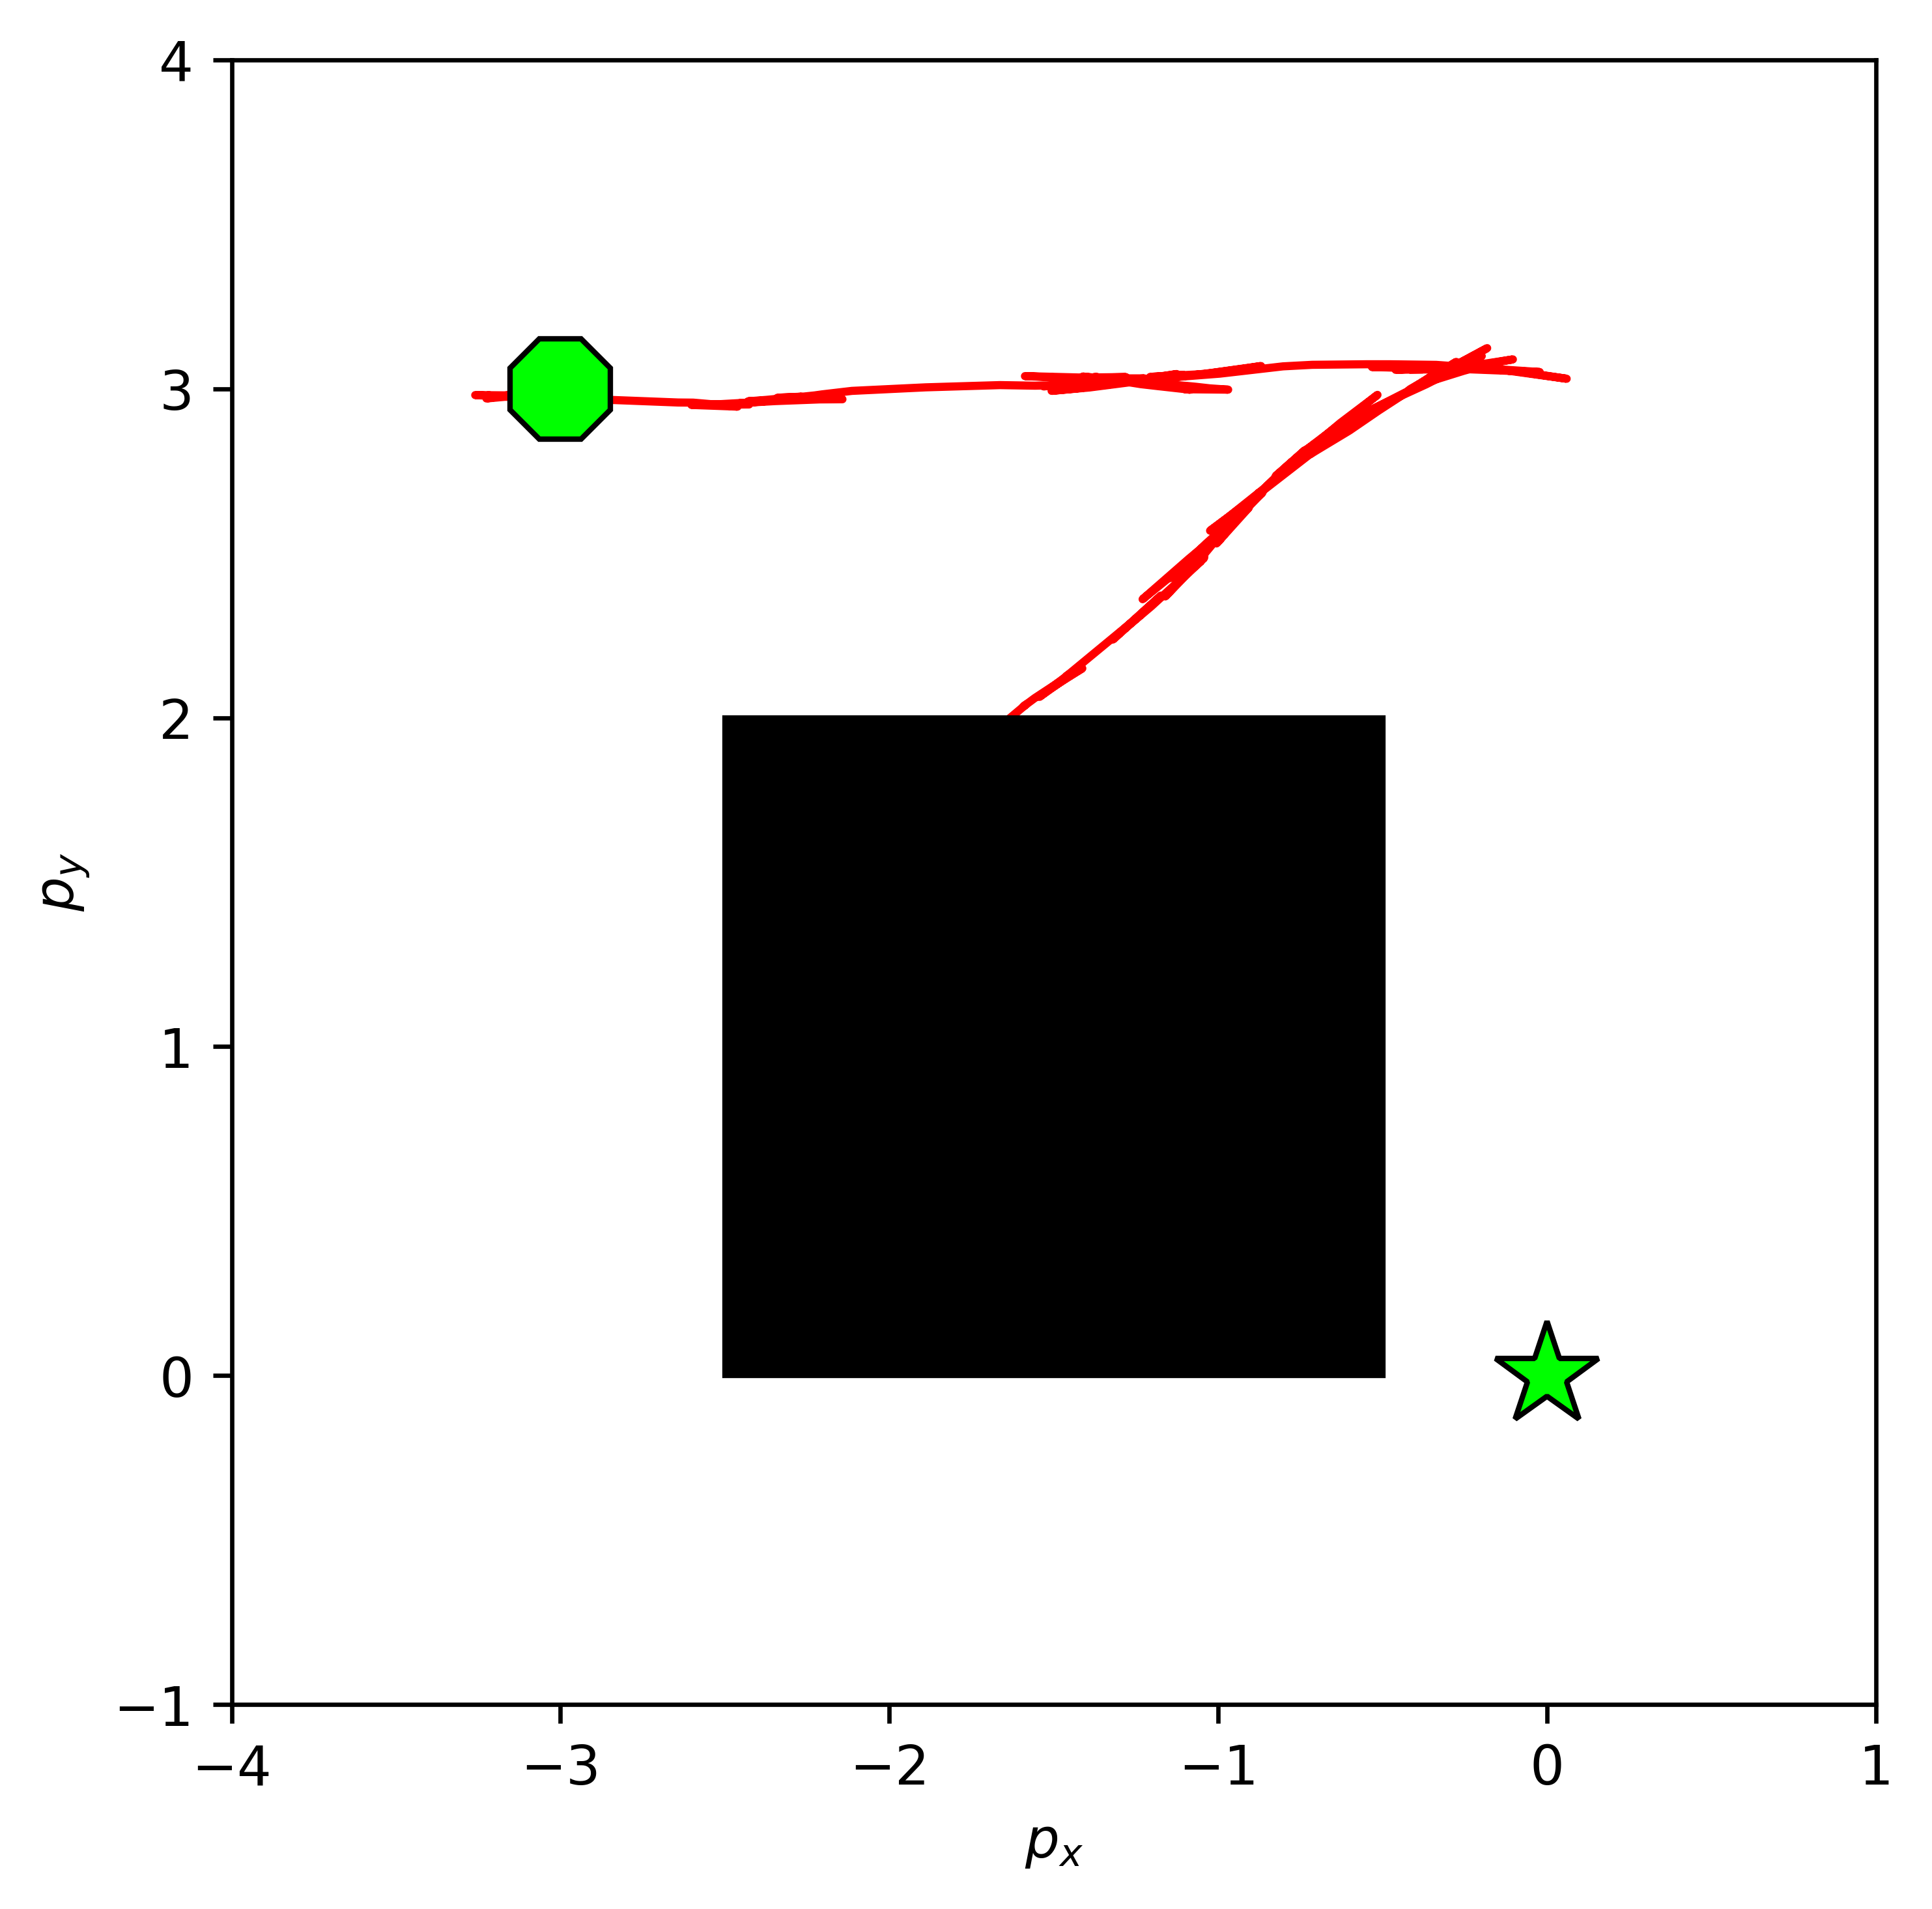

Goal reached at t=29.30s


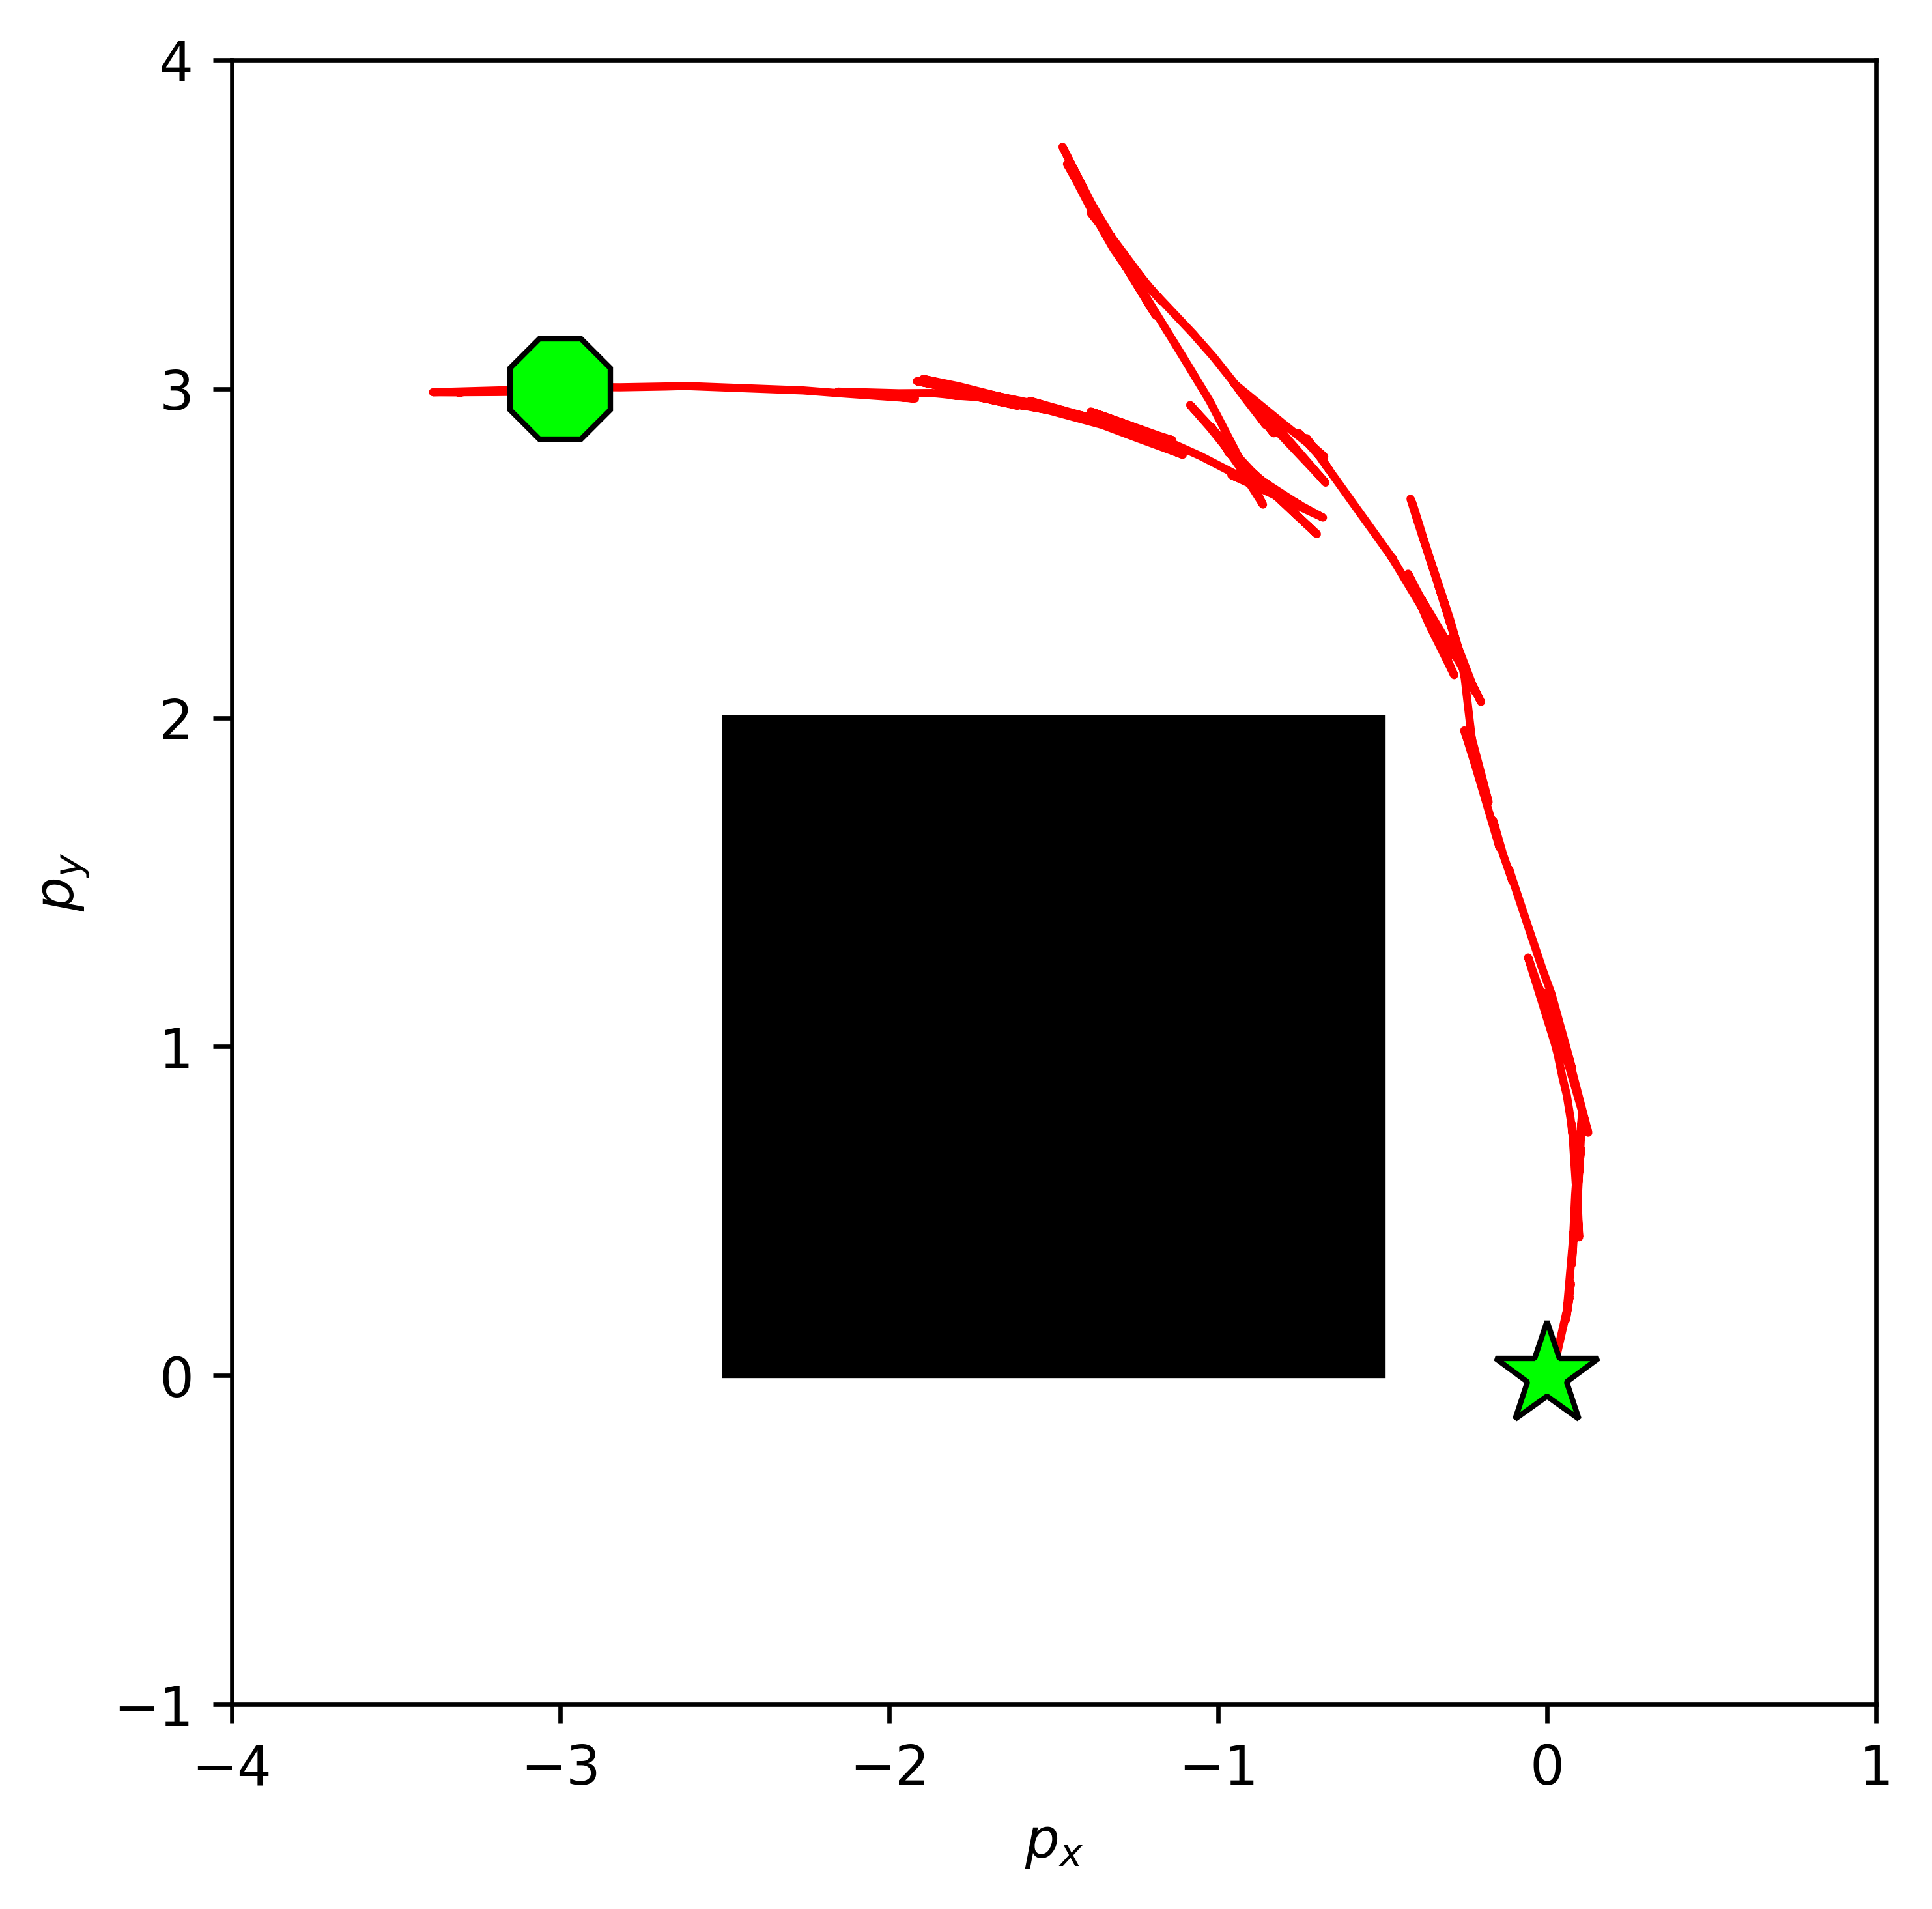

Hit obstacle


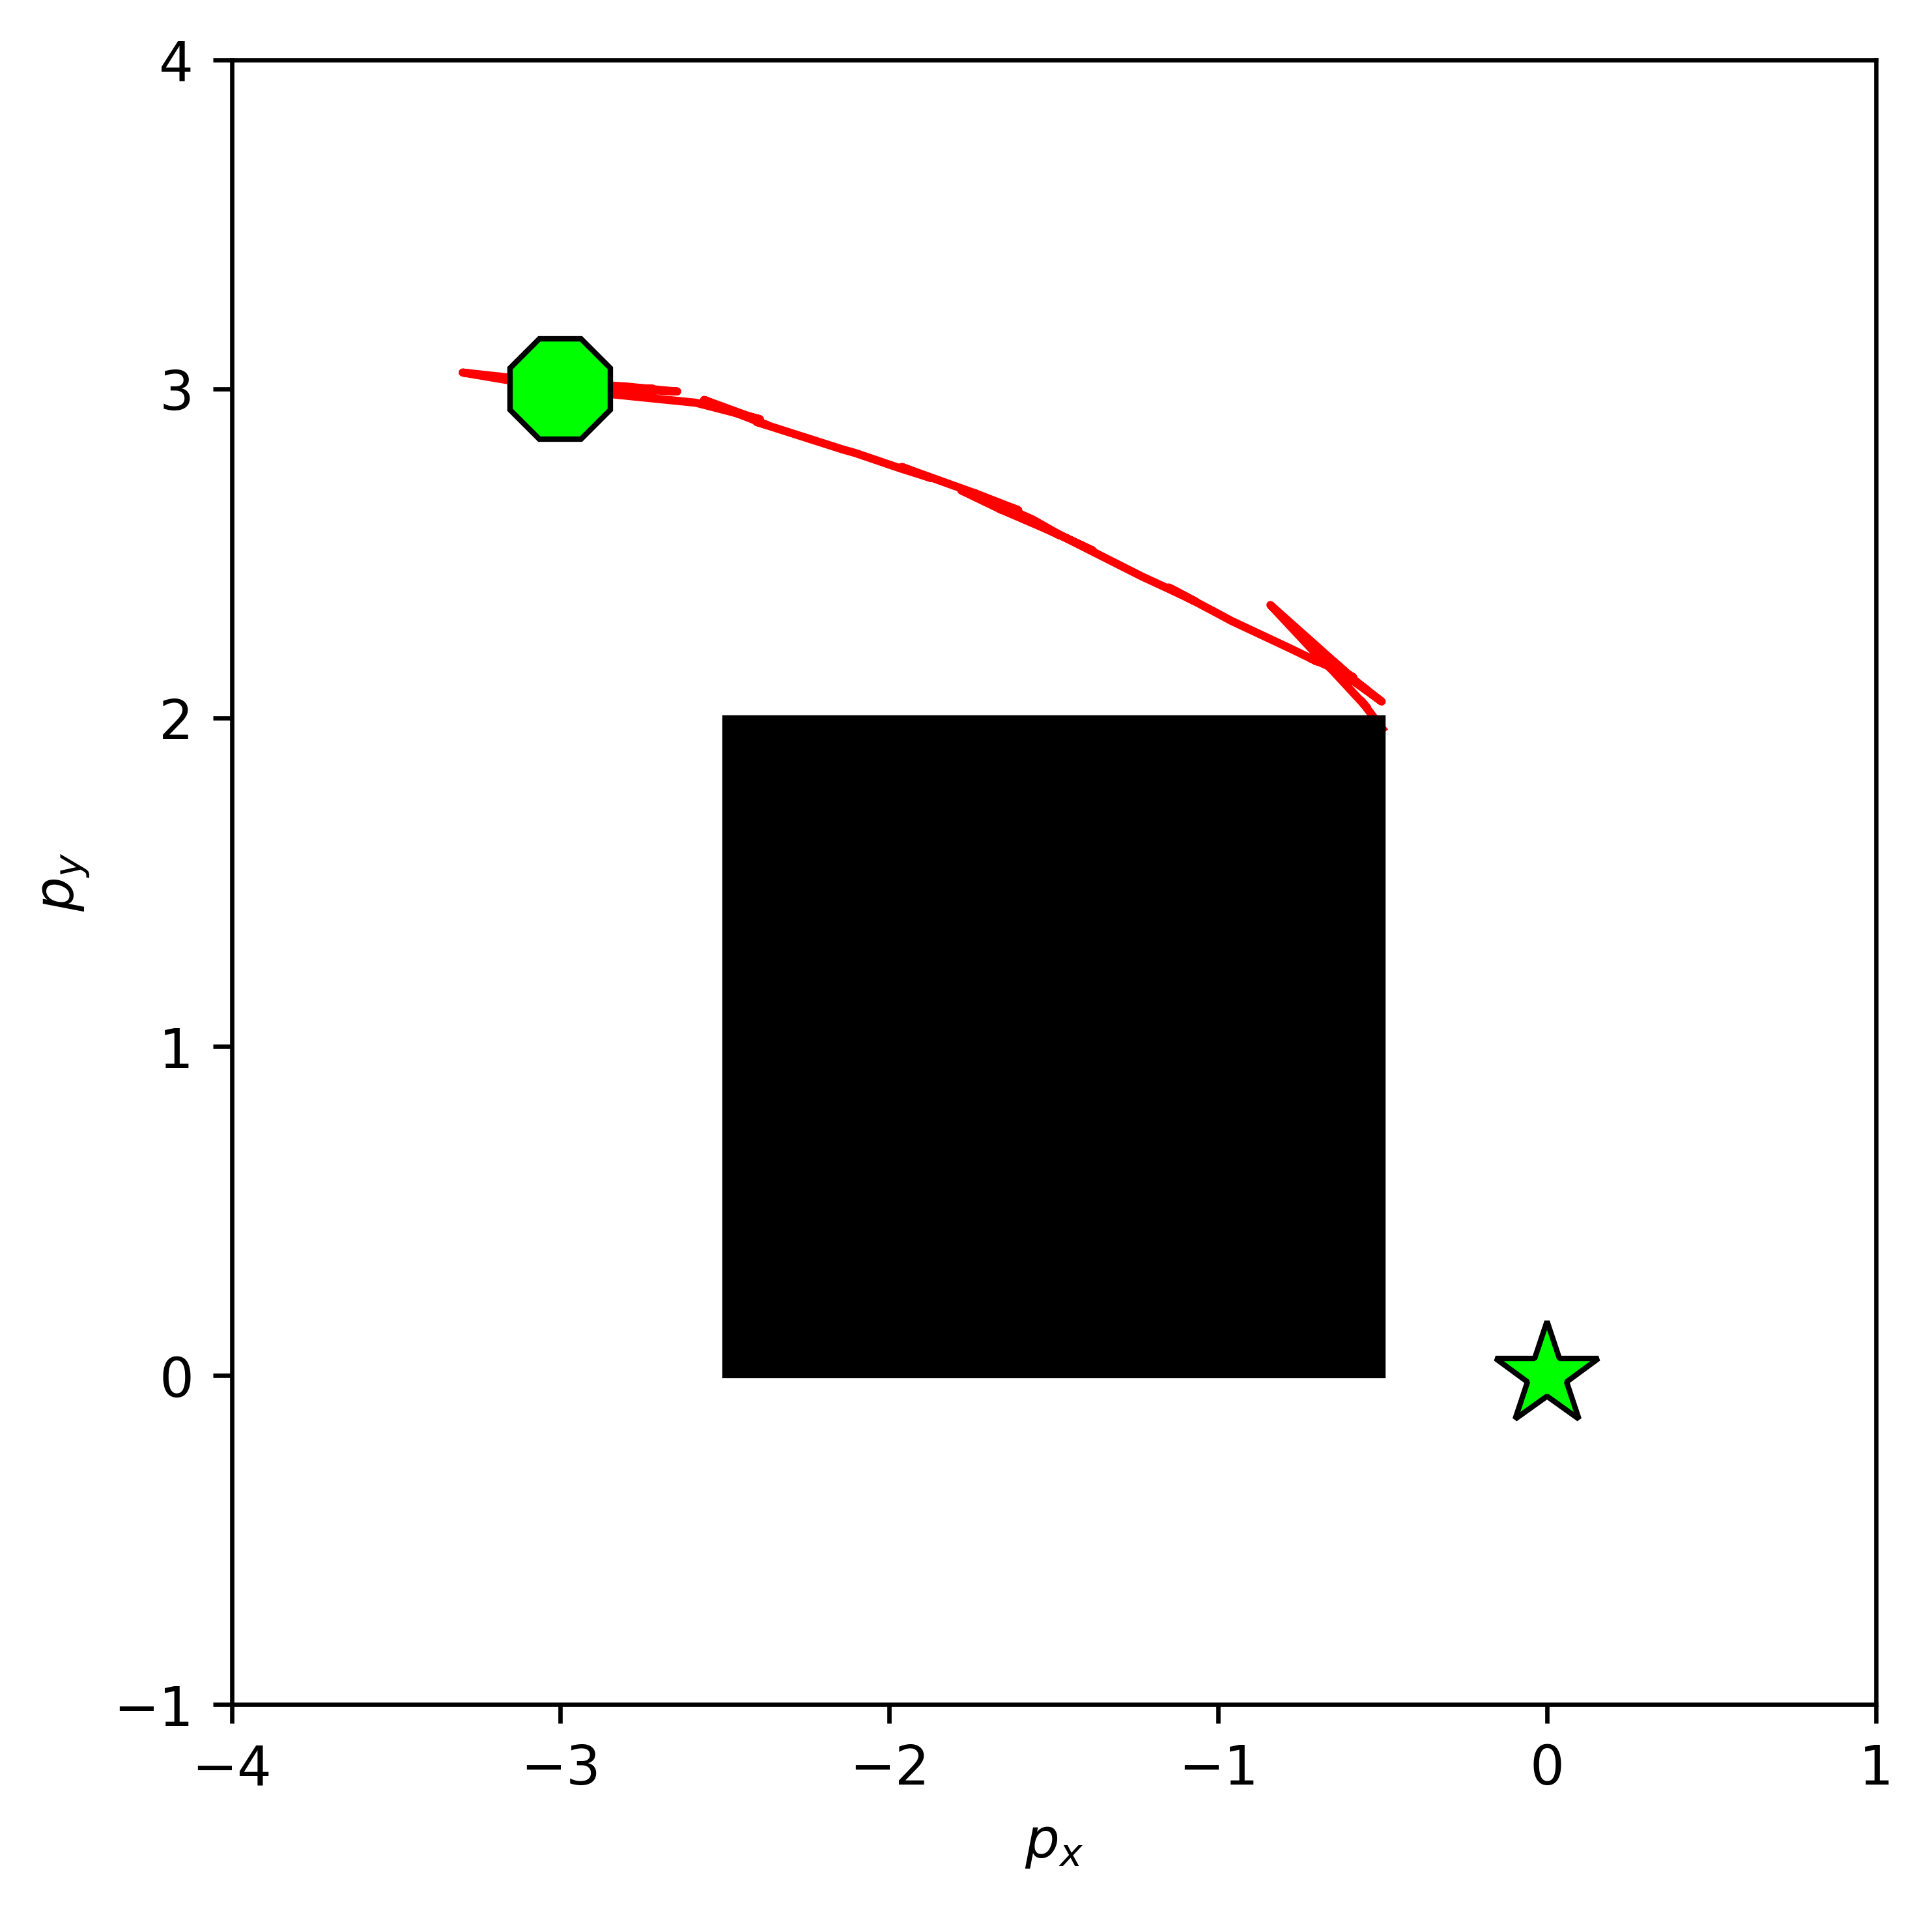

KeyboardInterrupt: 

In [40]:


# # %%

# # Model parameters
# # obstacle_positions = np.array([[-0.20, 0.05],[-0.05, 0.25]])
# # obstacle_radius = np.array([0.15, 0.05])
# # obstacle_positions = np.array([[-0.3, 0.0],[-0.1, 0.25]])
# # obstacle_radius = np.array([0.20, 0.15])

# # obstacle_positions = np.array([[-2.5, 0.0],[-0.5, 2.5]])
# # obstacle_radius = np.array([2.0, 2.5])
# obstacle_positions = np.array([[-2.5, 0.0]])
# obstacle_radius = np.array([2.0])
# # obstacle_positions = np.array([[-0.25, 0.0],[0.05, 0.35]])
# # obstacle_radius = np.array([0.20, 0.15])

# x_goal = np.array([0,0])
# # x0 = np.array([0.0, 0.0])
# x0 = np.array([-3.0, 3.0, 0])

# # Nominal Error dist 
# n_data = 50
# true_Sigma = np.array([[1, 0.0],
#                         [0.0,   0.1]])
# # Sigma = np.identity(2)*0.01
# errors = np.random.multivariate_normal( np.zeros(2), true_Sigma, n_data)
# Sigma  = 1/(n_data-1) * (errors).T @ (errors)

# obs_cost = 1e3
# dist_weight = 0.01
# # gamma = [200]
# # gamma = [400]
# gamma = [0]
# T = 10.0
# dt = 0.1
# # T = 2.0
# # dt = 0.05
# theta = 0.01
# goal_tolerance = 0.1
# num_trajs = 50

# # Simulation
# max_steps = 600
# u_curr = np.zeros((int(T//dt), 2))
# # u_curr = np.ones((int(T//dt), 2))*-0.5*dt
# x_hist = np.zeros( (max_steps+1, 3) )*np.nan
# u_hist = np.zeros( (max_steps+1, 2) )*np.nan
# x_hist[0] = x0

# # vis_xlim = [-0.4, 0.1]
# # vis_ylim = [-0.1, 0.4]
# vis_xlim = [-4.0, 1.0]
# vis_ylim = [-1.0, 4.0]


# hit_obstacle = False
# hit_boundary = False
# plot_every_n = 10
# for t in range(max_steps) :
#     # Solve
#     # u_curr = path_integral(Sigma, x0, x_goal, obstacle_positions, obstacle_radius, T, dt, theta)
#     u_curr, x_vis = path_integral(Sigma, x_hist[t], x_goal, u_curr, dist_weight, 
#                             obs_cost, obstacle_positions, obstacle_radius, 
#                             T, dt, theta, num_trajs, init_report=t, gammas=gamma)
#     # u_curr = u_currs[t,:]
#     # u_curr = np.array([0.01, 0.01])
#     u_hist[t] = u_curr[0]
    
#     # Simulate stochastic dynamics under control channel noise
#     u_noise = np.random.multivariate_normal(np.zeros(2), true_Sigma)
#     # x_hist[t+1] = x_hist[t] + dt*(u_curr[0] + u_noise)
    
#     # x_hist[t+1] =np.array([[1, 0, dt, 0],
#     #                         [0, 1, 0, dt],
#     #                         [0, 0, 1, 0],
#     #                         [0, 0, 0, 1]]) @ x_hist[t] + np.array([[(dt**2)/2, 0],[0, (dt**2)/2],[dt, 0],[0, dt]]) @ (u_curr[0] + u_noise)    
    
#     x_hist[t+1,0] = x_hist[t,0] + dt * ( u_curr[0,0] + u_noise[0] ) * np.cos(x_hist[t,2])
#     x_hist[t+1,1] = x_hist[t,1] + dt * ( u_curr[0,0] + u_noise[0]  ) * np.sin(x_hist[t,2])
#     x_hist[t+1,2] = x_hist[t,2] + dt * ( u_curr[0,1] + u_noise[1]  )
    
#     if t % plot_every_n == 0 :
#         # Visualize the basic setup
#         fig, ax = plt.subplots()
#         ax.plot([x0[0]], [x0[1]], '8', markersize = 10, markerfacecolor = 'k', label = 'Initial State',markeredgecolor = 'none' )
#         # ax.plot([x_hist[t+1,0]], [x_hist[t+1,1]], 'ro', markersize = 5, label = 'Curr. State', zorder =5 )
#         # c1 = plt.Circle(x_goal, goal_tolerance, color = 'b', linewidth = 3, fill=False, zorder = 7)
#         ax.plot([x_goal[0]], [x_goal[1]], '*', markersize = 10, markerfacecolor = 'k', label = 'Target State',markeredgecolor = 'none' )
#         # ax.add_patch(c1)
        
#         # Show obstacles
#         for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius) :
#             # obs = plt.Circle(obs_pos, obs_r, color='k', fill=True, zorder=6)
#             obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
#             ax.add_patch(obs)
        
#         # Track the realized trajectoy
#         ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
        
#         # Get rollout states from subset of maps for visualization
#         ax.plot(x_vis[:,:,0].T, x_vis[:,:,1].T, 'k', alpha=0.1, zorder=3)
        
        
#         ax.set_xlim(vis_xlim)
#         ax.set_ylim(vis_ylim)
        
#         # ax.legend(loc='lower left')
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
#         ax.set_aspect('equal')
#         plt.tight_layout()
#         # plt.savefig(f'simulation\plot_{t}.png')
#         plt.show()
        
#     for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius) :
#         if (x_hist[t+1,0] > obs_pos[0] and x_hist[t+1,0] < obs_pos[0] + obs_r and 
#             x_hist[t+1,1] > obs_pos[1] and x_hist[t+1,1] < obs_pos[1] + obs_r) :
            
#             hit_obstacle = True
#             print("Hit obstacle")
    
#     # Boundary 
#     if (x_hist[t+1,0] < -4 or x_hist[t+1,0] > 1  or x_hist[t+1,1] < -1 or x_hist[t+1,1] > 4 )  :
#         hit_boundary = True
#         print("Hit boundary")
        
    
#     if hit_obstacle == True or hit_boundary == True :
#         break
    
#     # Goal check
#     if np.linalg.norm(x_hist[t+1, :2] - x_goal) <= goal_tolerance :
#         print("Goal reached at t={:.2f}s".format(t*dt))
#         break
    
# fig, ax = plt.subplots(figsize=(12,3))
# ax.plot(u_hist[:,0], label='x_accel')
# ax.plot(u_hist[:,1], label='y_accel')
# ax.legend()
# plt.show()

# %%
# Construct 2D True Gaussian Mixture Dist 
def GMM(true_mus, true_covs, true_probs) :
    acc_probs = [np.sum(true_probs[:i]) for i in range(1, len(true_probs)+1)]   
    r = np.random.uniform(0,1)
    k = 0
    for i, threshold in enumerate(acc_probs):
        if r < threshold:
            k = i
            break
    selected_mu = true_mus[k]
    selected_cov = true_covs[k]
    contorl_noise =  np.random.multivariate_normal(selected_mu,selected_cov)
    
    return contorl_noise

true_mus = [np.array([-0.1, 0]), np.array([0.1, 0])]
true_covs = [ np.array([[0.01,0],[0,0.01]]), np.array([[0.01,0],[0,0.01]]) ]
true_probs = np.array([0.5, 0.5])




# %%
num_simulation = 100
max_steps = 600
x_hists = np.zeros( (num_simulation, max_steps+1, 2) )*np.nan
success_time = []
success_index = []
fail_index = []
# Model parameters
for k in range(num_simulation) :
    terminate = False
    obstacle_positions = np.array([[-2.5, 0.0]])
    obstacle_radius = np.array([2.0])
    
    x_goal = np.array([0,0])
    x0 = np.array([-3.0, 3.0, 0])
    
    # Nominal Error dist 
    n_data = 10
    ###################### GMM ################################
    # errors = np.zeros( (n_data, 2) )*np.nan
    
    # true_mus = [np.array([-1.0, 0.0]), np.array([-1.0, 0.0])]
    # true_covs = [ np.array([[0.01,0],[0,0.01]]), np.array([[0.01,0],[0,0.01]]) ]
    # true_probs = np.array([0.5, 0.5])
    
    # for n in range(n_data) :
    #     errors[n,:] = GMM(true_mus, true_covs, true_probs)
    ##########################################################
    true_Sigma = np.array([[1, 0.0],
                            [0.0,   0.1]])
    errors = np.random.multivariate_normal( np.zeros(2), true_Sigma, n_data)
    Sigma  = 1/(n_data-1) * (errors).T @ (errors)
    
    obs_cost = 1e3
    dist_weight = 0.01
    gamma = [200]
    #gamma = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200]
    T = 10.0
    dt = 0.1
    theta = 0.01
    goal_tolerance = 0.1
    num_trajs = 100
    
    # Simulation
    u_curr = np.zeros((int(T//dt), 2))
    x_hist = np.zeros( (max_steps+1, 3) )*np.nan
    u_hist = np.zeros( (max_steps+1, 2) )*np.nan
    x_hist[0] = x0
    
    vis_xlim = [-4.0, 1.0]
    vis_ylim = [-1.0, 4.0]
    
    
    hit_obstacle = False
    hit_boundary = False
    for t in range(max_steps) :
        u_curr, x_vis = path_integral(Sigma, x_hist[t], x_goal, u_curr, dist_weight, 
                               obs_cost, obstacle_positions, obstacle_radius, 
                               T, dt, theta, num_trajs, init_report=t, gammas=gamma)
        u_hist[t] = u_curr[0]
        
        # Simulate stochastic dynamics under control channel noise
        u_noise = np.random.multivariate_normal(np.zeros(2), true_Sigma)
        # u_noise = GMM(true_mus, true_covs, true_probs)
        
        x_hist[t+1,0] = x_hist[t,0] + dt * ( u_curr[0,0] + u_noise[0] ) * np.cos(x_hist[t,2])
        x_hist[t+1,1] = x_hist[t,1] + dt * ( u_curr[0,0] + u_noise[0]  ) * np.sin(x_hist[t,2])
        x_hist[t+1,2] = x_hist[t,2] + dt * ( u_curr[0,1] + u_noise[1]  )
        
        
        for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius) :
            if (x_hist[t+1,0] > obs_pos[0] and x_hist[t+1,0] < obs_pos[0] + obs_r and 
                x_hist[t+1,1] > obs_pos[1] and x_hist[t+1,1] < obs_pos[1] + obs_r) :
                
                hit_obstacle = True
                terminate = True
                fail_index.append(k)
                print("Hit obstacle")
        
        if hit_obstacle == True :
            break
        
        # Boundary 
        if (x_hist[t+1,0] < -4 or x_hist[t+1,0] > 1  or x_hist[t+1,1] < -1 or x_hist[t+1,1] > 4 )  :
            hit_boundary = True
            terminate = True
            fail_index.append(k)
            print("Hit boundary")
            
        
        if hit_boundary == True :
            break
        
        # Goal check
        if np.linalg.norm(x_hist[t+1, :2] - x_goal) <= goal_tolerance :
            print("Goal reached at t={:.2f}s".format(t*dt))
            success_time.append(t*dt)
            terminate = True
            success_index.append(k)
            break
    
    x_hists[k, :t, :] = x_hist[:t, :2]

    if terminate == True:
    # if t % 5 == 0:
        # Visualize the basic setup
        fig, ax = plt.subplots()
        ax.plot([x0[0]], [x0[1]], '8', markersize = 20, markerfacecolor = 'lime', label = 'Initial State',markeredgecolor = 'k', zorder=6  )
        ax.plot([x_goal[0]], [x_goal[1]], '*', markersize = 20, markerfacecolor = 'lime', label = 'Target State',markeredgecolor = 'k', zorder=6  )
        
        # Show obstacles
        for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius) :
            obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)
        
        # Track the realized trajectoy
        ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
        # ax.plot(x_vis[:,:,0].T, x_vis[:,:,1].T, 'k', alpha=0.1, zorder=3)
        
        ax.set_xlim(vis_xlim)
        ax.set_ylim(vis_ylim)
        
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #   fancybox=True, shadow=True, ncol=5)
        ax.set_aspect('equal')
        plt.tight_layout()
        ax.set_xlabel(r'$p_{x}$')
        ax.set_ylabel(r'$p_{y}$')
        plt.gcf().set_dpi(600)
        plt.show()
    # %%


In [ ]:
# Visualize the basic setup
fig, ax = plt.subplots()
ax.plot([x0[0]], [x0[1]], '8', markersize = 20, markerfacecolor = 'lime', label = 'Initial State',markeredgecolor = 'k', zorder=6  )
ax.plot([x_goal[0]], [x_goal[1]], '*', markersize = 20, markerfacecolor = 'lime', label = 'Target State',markeredgecolor = 'k', zorder=6  )

# Show obstacles
for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius) :
    obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
    ax.add_patch(obs)

# Track the realized trajectoy
ax.plot(x_hists[success_index,:,0].T, x_hists[success_index,:,1].T, 'b', linewidth=0.8)
ax.plot(x_hists[fail_index,:,0].T, x_hists[fail_index,:,1].T, 'r', linewidth=0.8)
# ax.plot(x_vis[:,:,0].T, x_vis[:,:,1].T, 'k', alpha=0.1, zorder=3)

ax.set_xlim(vis_xlim)
ax.set_ylim(vis_ylim)
ax.set_xlabel(r'$p_{x}$')
ax.set_ylabel(r'$p_{y}$')
plt.gcf().set_dpi(600)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#   fancybox=True, shadow=True, ncol=5)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()